In [1]:
import random
from tqdm import tqdm
import warnings
import pandas as pd
import numpy as np
import networkx as nx
from scipy.sparse import hstack
from gensim.models import Word2Vec
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


unable to import 'smart_open.gcs', disabling that module


In [2]:
data_path = '../../data/bs140513_032310.csv'
raw_data = pd.read_csv(data_path)

# from `bank_sim_dat_exp.ipynb` previous analysis 
def cat_amount(v, mean, median):
    res = ""
    if v > mean:
        res = "above_mean"
    elif v < median:
        res = "below_median"
    elif v >= median and v <= mean:
        res = "in_between"
    return res

amount_data = raw_data["amount"]
mean_amount = amount_data.mean()
median_amount = amount_data.median()
raw_data["amount_cat"] = np.vectorize(cat_amount)\
(raw_data["amount"].values, mean_amount, median_amount)

pre_data = raw_data[["step", "customer", "age", "gender", "merchant", "category", "amount_cat", "fraud"]]
fraud_data = pre_data[pre_data["fraud"] == 1]
non_fraud_data = pre_data[pre_data["fraud"] == 0]

feat_cols = fraud_data.columns
print("List of feature columns used: {}".format(feat_cols))

f_train, f_test = train_test_split(fraud_data, test_size=0.2)
nf_train, nf_test = train_test_split(non_fraud_data, test_size=0.2)

train_df = pd.concat([f_train, nf_train]).sample(frac = 1)
test_df = pd.concat([f_test, nf_test]).sample(frac = 1)


List of feature columns used: Index(['step', 'customer', 'age', 'gender', 'merchant', 'category',
       'amount_cat', 'fraud'],
      dtype='object')


In [3]:
def get_randomwalk(node, path_length, graph):
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(graph.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [4]:
train_G = nx.from_pandas_edgelist(train_df, source="customer", target="merchant",\
                                  edge_attr=True, create_using=nx.Graph())
test_G = nx.from_pandas_edgelist(test_df, source="customer", target="merchant",\
                                 edge_attr=True, create_using=nx.Graph())

# train_G = nx.from_pandas_edgelist(train_df, source="customer", target="merchant",\
#                                   edge_attr=True, create_using=nx.Graph())
# test_G = nx.from_pandas_edgelist(test_df, source="customer", target="merchant",\
#                                  edge_attr=True, create_using=nx.Graph())


train_nodes = list(train_G.nodes())
test_nodes = list(test_G.nodes())

train_walks = []
for n in tqdm(train_nodes):
    for i in range(5):
        train_walks.append(get_randomwalk(n, 10, train_G))
        
test_walks = []
for n in tqdm(test_nodes):
    for i in range(5):
        test_walks.append(get_randomwalk(n, 10, test_G))

100%|██████████| 4148/4148 [00:25<00:00, 162.55it/s]


In [5]:
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(train_walks + test_walks, progress_per=2)
model.train(train_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(2836401, 4161960)

In [6]:
train_graph_feat = model.wv[train_nodes]
test_graph_feat = model.wv[test_nodes]

train_graph_dict = dict(zip(train_nodes, train_graph_feat))
test_graph_dict = dict(zip(test_nodes, test_graph_feat))

In [7]:
# Map the nodes with their mass weight
def map_val(row, mass_map):
    return mass_map[row[0]]
# Map all customers/source
# Training data
train_customer_vec = np.apply_along_axis(map_val, 1, train_df["customer"].values.reshape(-1, 1),\
                                         train_graph_dict)
# Test data
test_customer_vec = np.apply_along_axis(map_val, 1, test_df["customer"].values.reshape(-1, 1),\
                                        test_graph_dict)
# Map all merchants/targets
# Training data
train_merchant_vec = np.apply_along_axis(map_val, 1, train_df["merchant"].values.reshape(-1, 1),\
                                         train_graph_dict)
# Test data
test_merchant_vec = np.apply_along_axis(map_val, 1, test_df["merchant"].values.reshape(-1, 1),\
                                        test_graph_dict)
# Select the required columns
train_data = train_df[["step", "age", "category", "amount_cat", "fraud"]]
test_data = test_df[["step", "age", "category", "amount_cat", "fraud"]]

In [8]:
cat_cols = ["step", "age", "category", "amount_cat"]

X_train = train_data[["step", "age", "category", "amount_cat"]].values
y_train = train_data["fraud"].values

X_test = test_data[["step", "age", "category", "amount_cat"]].values
y_test = test_data["fraud"].values

X_train_enc = np.array([[None] * len(cat_cols)] * X_train.shape[0])
# Transform categorical columns for training data
label_ens = []
for i in range(0, len(cat_cols)):
    en = LabelEncoder()
    X_train_enc[:, i] = en.fit_transform(X_train[:, i])
    label_ens.insert(i, en)

one_hot_en = OneHotEncoder(handle_unknown='ignore')
X_train_arr = hstack((one_hot_en.fit_transform(X_train_enc[:, 0:len(cat_cols)]),\
                     train_customer_vec, train_merchant_vec))

X_test_enc = np.array([[None] * len(cat_cols)] * X_test.shape[0])
# Transform categorical columns for test data
for i in range(0, len(cat_cols)):
    X_test_enc[:, i] = label_ens[i].transform(X_test[:, i])

X_test_arr = hstack((one_hot_en.transform(X_test_enc[:, 0:len(cat_cols)]),\
                    test_customer_vec, test_merchant_vec))

In [9]:
y_color = []
for i in y_train:
    if i == 0:
        y_color.append("g")
    else:
        y_color.append("r")
y_color = np.array(y_color)

In [10]:
dot = []
for i in range(len(train_customer_vec)):
    dot.append(np.dot(train_customer_vec[i], train_merchant_vec[i]))
dot = np.array(dot).reshape(-1, 1) 

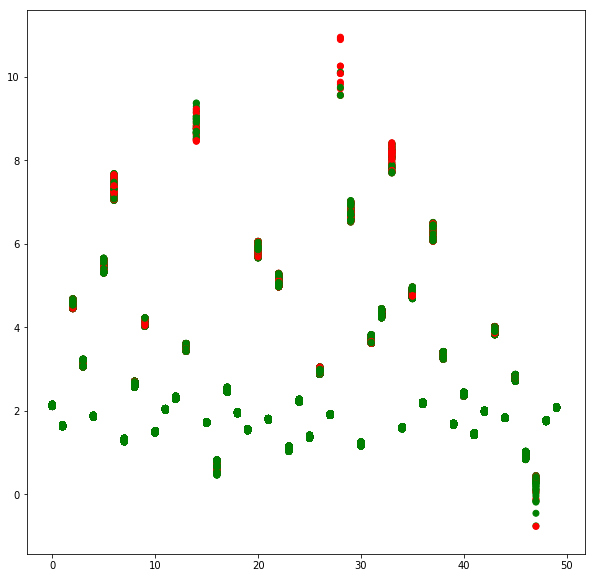

<Figure size 432x288 with 0 Axes>

In [16]:
from sklearn.cluster import KMeans
kmeans50 = KMeans(n_clusters=50, random_state=0).fit(dot)
kmeans50.labels_

fig = plt.gcf()
fig.set_size_inches(10, 10)

centers = kmeans50.cluster_centers_
# create scatter plot for samples from each class
for class_value in range(50):
    # get row indexes for samples with this class
    ids = np.where(kmeans50.labels_ == class_value)
    y = [class_value for i in range(len(ids[0]))]
    plt.scatter(y, dot[ids], c=y_color[ids])
#     plt.scatter(class_value, centers[class_value], label=class_value, c="black", marker="s")

# show the plot
plt.show()
fig.savefig("kmeans_50.jpg")
plt.clf()

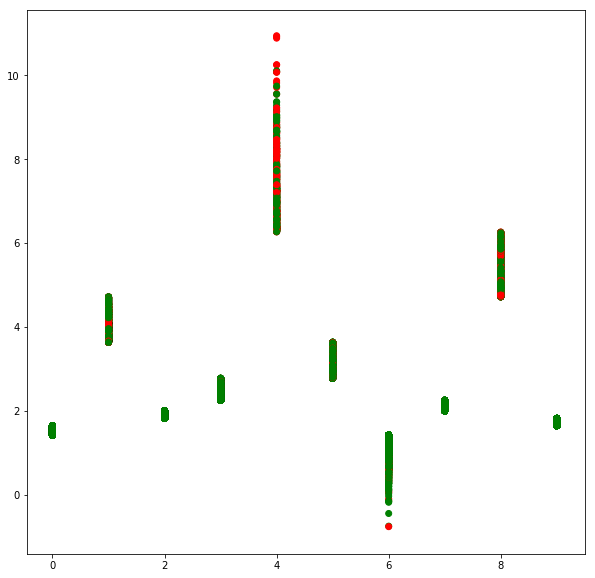

<Figure size 432x288 with 0 Axes>

In [17]:
kmeans10 = KMeans(n_clusters=10, random_state=0).fit(dot)
kmeans10.labels_

fig = plt.gcf()
fig.set_size_inches(10, 10)

centers = kmeans10.cluster_centers_
points = kmeans10.labels_

# create scatter plot for samples from each class
for class_value in range(10):
    # get row indexes for samples with this class
    ids = np.where(kmeans10.labels_ == class_value)
    y = [class_value for i in range(len(ids[0]))]
    plt.scatter(y, dot[ids], c=y_color[ids])
#     plt.scatter(class_value, centers[class_value], label=class_value, c="black", marker="s")

# show the plot
plt.show()
fig.savefig("kmeans_10.jpg")
plt.clf()

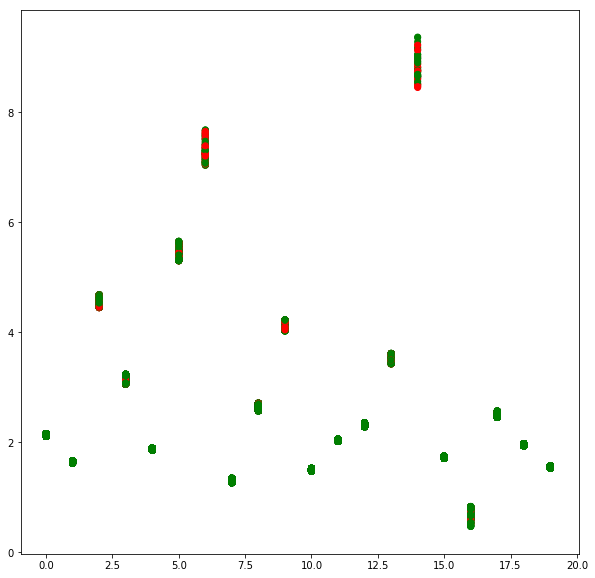

<Figure size 432x288 with 0 Axes>

In [18]:
kmeans20 = KMeans(n_clusters=20, random_state=0).fit(dot)
kmeans20.labels_

fig = plt.gcf()
fig.set_size_inches(10, 10)

centers = kmeans20.cluster_centers_
points = kmeans20.labels_

# create scatter plot for samples from each class
for class_value in range(20):
    # get row indexes for samples with this class
    ids = np.where(kmeans50.labels_ == class_value)
    y = [class_value for i in range(len(ids[0]))]
    plt.scatter(y, dot[ids], c=y_color[ids])
#     plt.scatter(class_value, centers[class_value], label=class_value, c="black", marker="s")

# show the plot
plt.show()
fig.savefig("kmeans_20.jpg")
plt.clf()


100%|██████████| 24/24 [36:35<00:00, 91.47s/it] 


K list: [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]


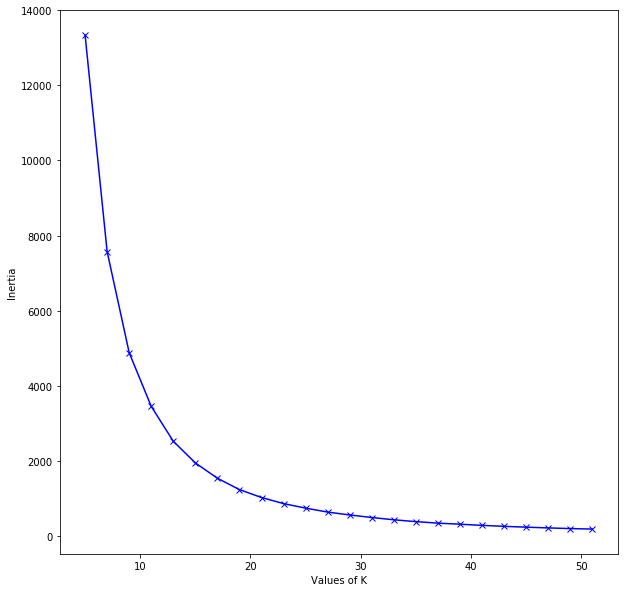

<Figure size 432x288 with 0 Axes>

In [12]:
#Finding Kmeans elbow using inertia_
from sklearn.cluster import KMeans
K = range(5, 52, 2)

#Sum of squared distances of samples to their closest cluster center.
distances = []
for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(dot)
    distances.append(kmeans.inertia_)
    
print("K list:", list(K))
fig = plt.gcf()
fig.set_size_inches(10, 10)

plt.plot(K, distances, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.show() 
fig.savefig("kmeans_elbow.jpg")
plt.clf()

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]


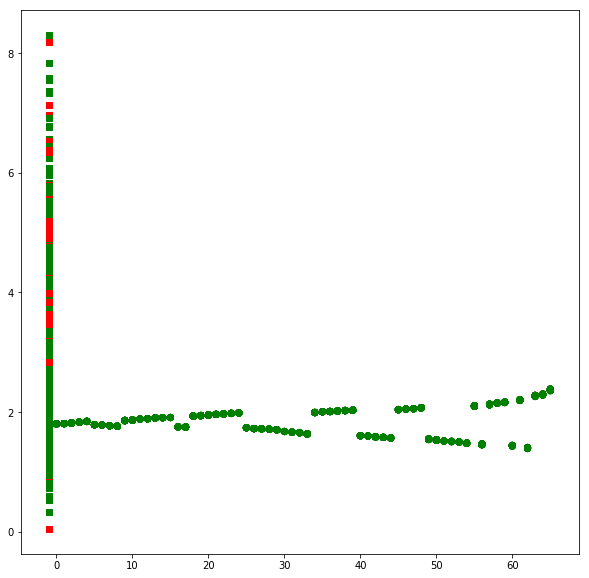

<Figure size 432x288 with 0 Axes>

In [19]:
X = dot[:10000]
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=50).fit(X)
l = optics.labels_

print(np.unique(l))

fig = plt.gcf()
fig.set_size_inches(10, 10)

# create scatter plot for samples from each class
for class_value in range(0, l.max(), 1):
    ids = np.where(l == class_value)
    y = [class_value for i in range(len(ids[0]))]
    plt.scatter(y, X[ids], c=y_color[ids])


ids = np.where(l == -1)
# create scatter of these samples
y = [-1 for i in range(len(ids[0]))]
plt.scatter(y, X[ids], c=y_color[ids], marker="s")

# show the plot
plt.show()
fig.savefig("optics_50.jpg")
plt.clf()

[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 24

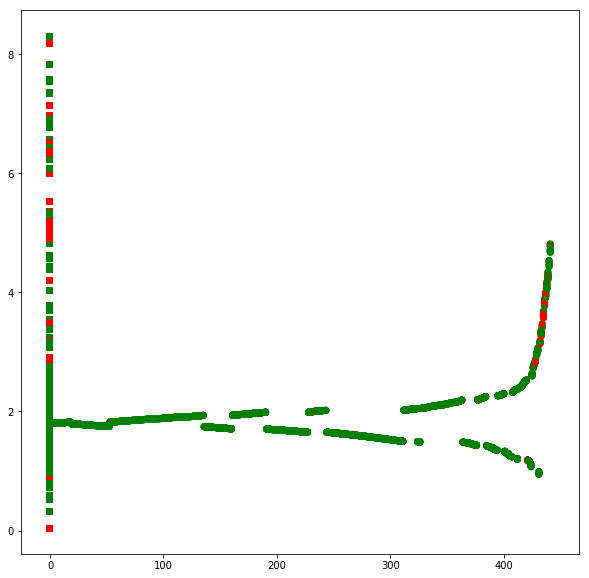

<Figure size 432x288 with 0 Axes>

In [20]:
X = dot[:10000]
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=10).fit(X)
l = optics.labels_

print(np.unique(l))

fig = plt.gcf()
fig.set_size_inches(10, 10)

# create scatter plot for samples from each class
for class_value in range(0, l.max(), 1):
    ids = np.where(l == class_value)
    y = [class_value for i in range(len(ids[0]))]
    plt.scatter(y, X[ids], c=y_color[ids])

ids = np.where(l == -1)
# create scatter of these samples
y = [-1 for i in range(len(ids[0]))]
plt.scatter(y, X[ids], c=y_color[ids], marker="s")

# show the plot


# show the plot
plt.show()
fig.savefig("optics_10.jpg")
plt.clf()

[0 1 2 3 4 5 6 7 8]


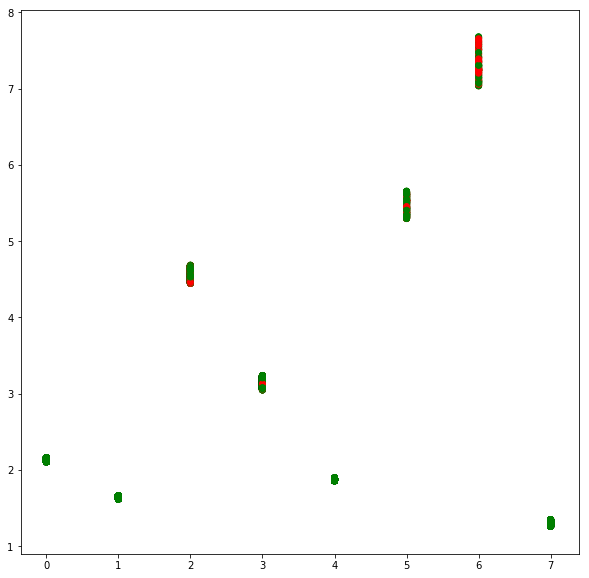

<Figure size 432x288 with 0 Axes>

In [21]:
from sklearn.cluster import Birch
brc = Birch(n_clusters=None).fit(dot)
l = brc.predict(dot)
print(np.unique(l))

fig = plt.gcf()
fig.set_size_inches(10, 10)
centers = brc.subcluster_centers_

# create scatter plot for samples from each class
for class_value in range(0, l.max(), 1):
    # get row indexes for samples with this class
    ids = np.where(kmeans50.labels_ == class_value)
    y = [class_value for i in range(len(ids[0]))]
    plt.scatter(y, dot[ids], c=y_color[ids])
#     plt.scatter(class_value, centers[class_value], label=class_value, c="black", marker="s")

# show the plot
plt.show()
fig.savefig("Birch.jpg")
plt.clf()

[0 1 2 3 4 5 6 7 8 9]


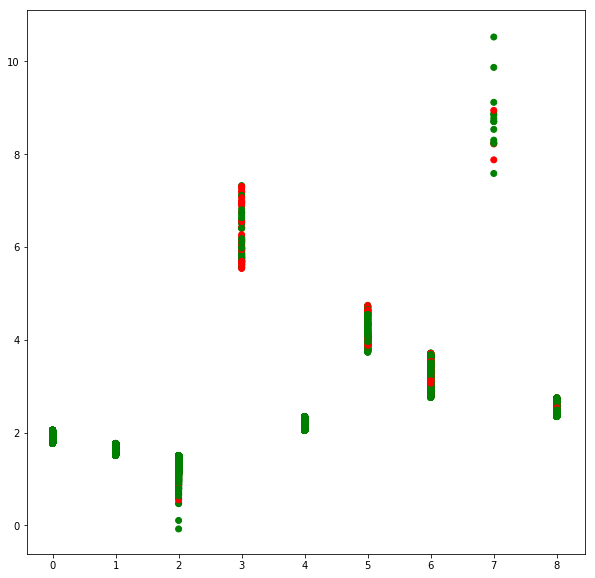

<Figure size 432x288 with 0 Axes>

In [17]:
X = dot[:30000]
from sklearn.cluster import AgglomerativeClustering
aglo = AgglomerativeClustering(n_clusters=10).fit(X)

l = aglo.labels_
print(np.unique(l))

fig = plt.gcf()
fig.set_size_inches(10, 10)

# create scatter plot for samples from each class
for class_value in range(0, l.max(), 1):
    # get row indexes for samples with this class
    i = np.where(l == class_value)
    # create scatter of these samples
    y = [class_value for i in range(len(i[0]))]
    plt.scatter(y, dot[i], c=y_color[i])
# show the plot
plt.show()
fig.savefig("AgglomerativeClustering.jpg")
plt.clf()

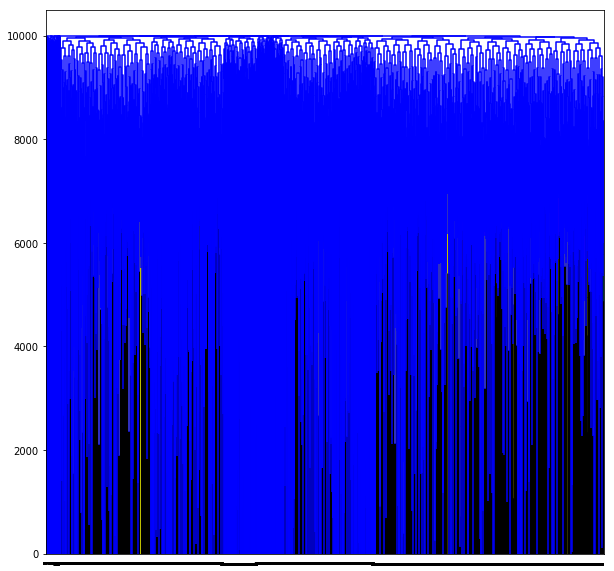

In [57]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

fig = plt.gcf()
fig.set_size_inches(10, 10)
plot_dendrogram(aglo, labels=aglo.labels_)
plt.show()

In [21]:
X = dot[:30000]
np.random.shuffle(X)
X.reshape(-1, 1)
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=3, min_samples=10).fit(X)
dbscan.labels_
np.unique(dbscan.labels_)

array([0], dtype=int64)